# Running in parallel with FOSI forcing

This is similar to the `matlab-comparison.ipynb` notebook, but provides an example of parallelizing the driver.
Parallelization is only necessary with large domains, so only the FOSI forcing sets are available.

## Running the model

Setup a `feisty` integration.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import time

import dask
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import yaml
from dask.distributed import Client
from dask_jobqueue import PBSCluster
from utils import compare_nc, default_config, old_settings
from xarray.tests import raise_if_dask_computes

import feisty

%matplotlib inline

/glade/work/mlevy/miniconda3/envs/dev-feisty/lib/python3.10/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


## Configure run

There are a few options on how to run:

1. `FOSI_spinup` cycles through the first year of 68 years of forcing generated from a CESM; its purpose is to provide equilibriated initial conditions
1. `FOSI_cesm` uses initial conditions from `FOSI_spinup` but the full 68 years of forcing from CESM to allow biomass to evolve

Note that both of these options run on the 85813 active ocean cells from the POP `gx1v7` grid.

In [3]:
# matlab_script = 'FOSI_spinup'
matlab_script = 'FOSI_cesm'

In [4]:
# Configuration settings for the offline driver as well as output generated in this notebook
driver_config = default_config()

# configurations that differ from default
driver_config['FOSI_cesm']['nyears'] = 15
driver_config['FOSI_spinup']['ignore_year_in_forcing'] = True
driver_config['FOSI_spinup']['nyears'] = 100
for matlab_script_loc in ['FOSI_cesm', 'FOSI_cesm_daily', 'FOSI_spinup']:
    driver_config[matlab_script_loc]['baseline'] = 'FOSI_cesm.nc'
    driver_config[matlab_script_loc]['baseline_compare'] = False
    driver_config[matlab_script_loc]['num_chunks'] = 9
    if matlab_script_loc != 'FOSI_spinup':
        driver_config[matlab_script_loc]['start_date'] = '0249-01-01'
        driver_config[matlab_script_loc]['make_err_plots'] = True
    driver_config[matlab_script_loc]['compare_forcing'] = False
    # diagnostic_names=driver_config[matlab_script_loc]['diagnostic_names'] = ['growth_rate']
    driver_config[matlab_script_loc]['plot_settings']['X'] = 55000  # looks good
    # driver_config[matlab_script_loc]['plot_settings']['X'] = 15633  # large error in small classes
    # driver_config[matlab_script_loc]['plot_settings']['X'] = 11677  # large error in medium classes
    # driver_config[matlab_script_loc]['plot_settings']['X'] = 76989  # large error in benthic

<!-- ## Run the model -->

First we spin up a dask cluster

In [5]:
if driver_config[matlab_script]['num_chunks'] > 1:
    ncores = np.minimum(driver_config[matlab_script]['num_chunks'], 9)
    dask.config.set({'distributed.dashboard.link': '/proxy/{port}/status'})
    # dask.config.set({"distributed.comm.timeouts.tcp": "180s"})
    # dask.config.set({"distributed.comm.timeouts.connect": "180s"})
    cluster = PBSCluster(
        memory='300 GB',
        processes=ncores,
        cores=ncores,
        queue='casper',
        walltime='1:00:00',
        resource_spec='select=1:ncpus=36:mem=300GB',
    )

    cluster.scale(1)
    client = Client(cluster)
else:
    client = None
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.36:37552,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


Then we read in baselines and set up chunking in X dimension

In [6]:
baselines_from_nc = xr.open_dataset(
    f'../matlab_baselines/{driver_config[matlab_script]["baseline"]}'
)

In [7]:
# Set up dask chunks?
if driver_config[matlab_script]['num_chunks'] > 1:
    nX = 85813
    chunks = dict(X=(nX - 1) // driver_config[matlab_script]['num_chunks'] + 1)
else:
    chunks = None

# Read forcing file, and add zooplankton dimension if necessary
ds = xr.open_dataset('../input_files/feisty_input_from_FOSI_monthly.nc', chunks=chunks).rename(
    {'dep': 'bathymetry', 'time': 'forcing_time'}
)
if 'zooplankton' not in ds.dims:
    ds['zooC'] = ds['zooC'].expand_dims('zooplankton')
    ds['zoo_mort'] = ds['zoo_mort'].expand_dims('zooplankton')
    ds['zooplankton'] = xr.DataArray(['Zoo'], dims='zooplankton')

# Read initial condition file, add fish_ic and bent_ic to ds
ds_ic = xr.open_dataset('../input_files/FOSI_cesm_init_200yr.nc', chunks=chunks).assign_coords(
    {'X': ds.X.data}
)
for var in ['fish_ic', 'bent_ic']:
    ds[var] = ds_ic[var]
ds

<xarray.Dataset>
Dimensions:          (X: 85813, forcing_time: 816, zooplankton: 1, nfish: 8,
                      nb: 1)
Coordinates:
  * forcing_time     (forcing_time) object 0249-01-16 12:00:00 ... 0316-12-16...
  * X                (X) float64 320.6 321.7 322.8 194.6 ... 302.5 302.7 302.9
  * zooplankton      (zooplankton) <U3 'Zoo'
Dimensions without coordinates: nfish, nb
Data variables:
    lat              (X) float64 dask.array<chunksize=(9535,), meta=np.ndarray>
    bathymetry       (X) float64 dask.array<chunksize=(9535,), meta=np.ndarray>
    T_pelagic        (forcing_time, X) float32 dask.array<chunksize=(816, 9535), meta=np.ndarray>
    T_bottom         (forcing_time, X) float32 dask.array<chunksize=(816, 9535), meta=np.ndarray>
    poc_flux_bottom  (forcing_time, X) float32 dask.array<chunksize=(816, 9535), meta=np.ndarray>
    zooC             (zooplankton, forcing_time, X) float32 dask.array<chunksize=(1, 816, 9535), meta=np.ndarray>
    zoo_mort         (zooplankton, forcing_time, X) float32 dask.array<chunksize=(1, 816, 9535), meta=np.ndarray>
    fish_ic          (nfish, X) float64 dask.array<chunksize=(8, 9535), meta=np.ndarray>
    bent_ic          (nb, X) float64 dask.array<chunksize=(1, 9535), meta=np.ndarray>

## Run!

In [8]:
%%time

print(f'Starting template generation at {time.strftime("%H:%M:%S")}')
# Create template for output (used for xr.map_blocks)
group = np.array(['Sf', 'Sp', 'Sd', 'Mf', 'Mp', 'Md', 'Lp', 'Ld', 'benthic_prey'], dtype='<U12')
model_time = xr.cftime_range(
    start=driver_config[matlab_script]['start_date'],
    periods=driver_config[matlab_script]['nyears'] * 365,
    calendar='noleap',
)
X = ds['X'].data

template = (
    xr.Dataset(
        data_vars=dict(
            biomass=(['time', 'group', 'X'], np.zeros((len(model_time), len(group), len(X))))
        ),
        coords=dict(time=(['time'], model_time), group=(['group'], group), X=(['X'], X)),
    )
    .assign_coords({'X': ds['X']})
    .chunk(chunks)
)
print(template)

print(f'\nStarting config_and_run_from_dataset at {time.strftime("%H:%M:%S")}')
ds_out = xr.map_blocks(
    feisty.config_and_run_from_dataset,
    ds,
    args=(
        driver_config[matlab_script]['nyears'] * 365,
        driver_config[matlab_script]['start_date'],
        driver_config[matlab_script]['ignore_year_in_forcing'],  # True,
        driver_config[matlab_script]['settings_in'],
        driver_config[matlab_script]['diagnostic_names'],
        driver_config[matlab_script]['max_output_time_dim'],
    ),
    template=template,
).compute()

print(f'Done at {time.strftime("%H:%M:%S")}')
ds_out

Starting template generation at 21:27:44
<xarray.Dataset>
Dimensions:  (time: 5475, group: 9, X: 85813)
Coordinates:
  * time     (time) object 0249-01-01 00:00:00 ... 0263-12-31 00:00:00
  * group    (group) <U12 'Sf' 'Sp' 'Sd' 'Mf' 'Mp' 'Md' 'Lp' 'Ld' 'benthic_prey'
  * X        (X) float64 320.6 321.7 322.8 194.6 ... 302.3 302.5 302.7 302.9
Data variables:
    biomass  (time, group, X) float64 dask.array<chunksize=(5475, 9, 9535), meta=np.ndarray>

Starting config_and_run_from_dataset at 21:28:17
Done at 21:33:09
CPU times: user 56.5 s, sys: 43.6 s, total: 1min 40s
Wall time: 5min 24s


<xarray.Dataset>
Dimensions:  (time: 5475, group: 9, X: 85813)
Coordinates:
  * time     (time) object 0249-01-01 00:00:00 ... 0263-12-31 00:00:00
  * group    (group) object 'Sf' 'Sp' 'Sd' 'Mf' ... 'Lp' 'Ld' 'benthic_prey'
  * X        (X) float64 320.6 321.7 322.8 194.6 ... 302.3 302.5 302.7 302.9
Data variables:
    biomass  (time, group, X) float64 1.27e-24 9.098e-25 ... 8.603 9.298

In [9]:
if 'new_restart_file' in driver_config[matlab_script]:
    feisty_driver.create_restart_file(driver_config[matlab_script]['new_restart_file'])

In [10]:
if driver_config[matlab_script]['baseline_compare']:
    compare_nc(baselines_from_nc, ds_out["biomass"], nsteps, thres=1e-15)

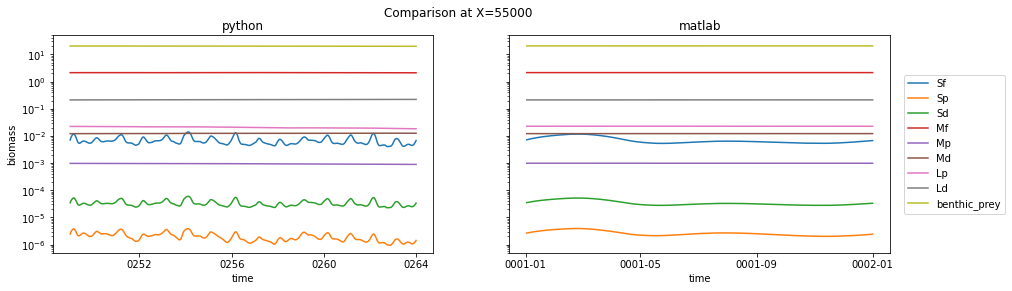

In [11]:
if driver_config[matlab_script]['make_plots']:
    if len(baselines_from_nc.time) > len(ds_out.time):
        isel_dict = {"time": range(len(ds_out.time))}
        baselines_tmp = baselines_from_nc.isel(isel_dict).assign_coords(
            {'group': ds_out.group.data, 'time': ds_out.time.data}
        )
    else:
        baselines_tmp = baselines_from_nc.assign_coords({'group': ds_out.group.data})
    fig, axs = plt.subplots(1, 2, figsize=(15, 4))
    for group in ds_out.group.data:
        ds_out.biomass.sel(group=group).isel(
            X=driver_config[matlab_script]['plot_settings']['X']
        ).plot(ax=axs[0])
        baselines_tmp.biomass.sel(group=group).isel(
            X=driver_config[matlab_script]['plot_settings']['X']
        ).plot(ax=axs[1])
    for ax in axs:
        ax.set_ylim(driver_config[matlab_script]['plot_settings']['ylim'])
        ax.set_yscale("log")
    axs[0].set_title("python")
    axs[1].set_title("matlab")
    axs[1].set_ylabel("")
    axs[1].set_yticklabels("")
    plt.legend(ds_out.group.data, bbox_to_anchor=(1.025, 0.5), loc=6)
    fig.suptitle(f"Comparison at X={driver_config[matlab_script]['plot_settings']['X']}")

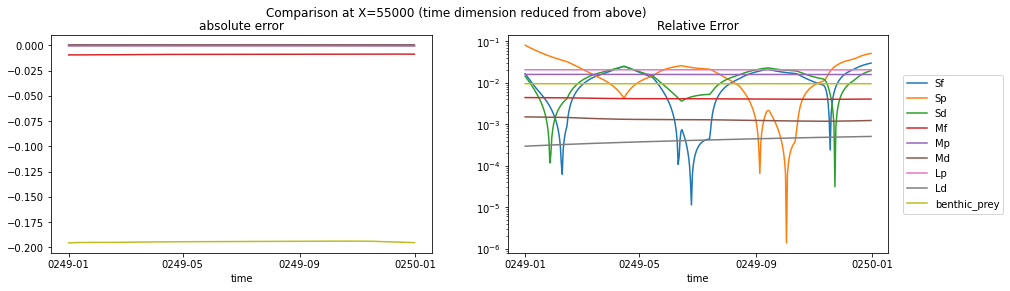

In [12]:
if driver_config[matlab_script]['make_err_plots']:
    fig, axs = plt.subplots(1, 2, figsize=(15, 4))
    for group in ds_out.group.data:
        da1 = ds_out.biomass.sel(group=group).isel(
            X=driver_config[matlab_script]['plot_settings']['X']
        )
        if len(baselines_from_nc.time) < len(ds_out.time):
            da1 = da1.isel({"time": range(len(baselines_from_nc.time))})
        da2 = (
            baselines_tmp.biomass.sel(group=group)
            .isel(X=driver_config[matlab_script]['plot_settings']['X'])
            .assign_coords({'time': da1.time.data})
        )
        (da1 - da2).plot(ax=axs[0])
        (np.abs(da1 - da2) / da2).plot(ax=axs[1])
    axs[0].set_title("absolute error")
    axs[0].set_ylabel("")
    axs[1].set_title("relative error")
    axs[1].set_ylabel("")
    axs[1].set_yscale("log")
    plt.legend(ds_out.group.data, bbox_to_anchor=(1.025, 0.5), loc=6)
    plt.title("Relative Error")
    fig_suptitle = f"Comparison at X={driver_config[matlab_script]['plot_settings']['X']}"
    if len(baselines_from_nc.time) < len(ds_out.time):
        fig_suptitle = f"{fig_suptitle} (time dimension reduced from above)"
    fig.suptitle(fig_suptitle)

In [13]:
if driver_config[matlab_script]['baseline_compare']:
    compare_nc(
        baselines_from_nc.isel(X=[driver_config[matlab_script]['plot_settings']['X']]),
        ds_out["biomass"].isel(X=[driver_config[matlab_script]['plot_settings']['X']]),
        nsteps,
        thres=1e-15,
    )